# Práctica 3: Algoritmos Genéticos
Autores: David Cabornero Pascual y Mario García Pascual

# 0. Introducción

En esta práctica se diseñará un algoritmo genético para clasificar los datos de dos bases de datos: tic-tac-toe.data y titanic.data. Durante esta práctica se ha mantenido el enfoque de Pittsburgh, es decir, cada individuo es un conjunto de reglas que clasifica la base de datos. 

Nos ha parecido procedente cambiar el orden de los apartados tal y como se estipulan. En concreto, es más interesante fijar primero los hiperparámetros óptimos (Apartado 3) y después analizar cómo influyen el número de épocas y individuos (Apartado 2). Además, como las ejecuciones son tan costosas se han guardado los resultado en *pickles*. Dichos resultados se irán mostrando a lo largo de la práctica.

A continuación se muestran todas las librerías cargadas, así como los datasets previos cargados:

In [28]:
from Clasificador import AlgoritmoGenetico, ClasificadorNaiveBayes
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# allNominal: nuevo atributo que fuerza a la clase Datos a interpretar todos los atributos como nominales
dataTitanic = Datos('titanic.data',allNominal=True)
dataTic = Datos('tic-tac-toe.data',allNominal=True)

# 1. Detalles de la implementación

Una población es una lista (de Python) de individuos, y cada individuo es un array de numpy de valores booleanos. A continuación hablamos de los detalles concretos de nuestra implementación, y explicamos brevemente los motivos de cada decisión de diseño.

## 1.1. Representación de los individuos

En nuestra implementación, representamos un individuo como un array de numpy de valores booleanos, True o False. Si la longitud de las reglas de nuestro problema es `ruleSize` y el individuo tiene 7 reglas, la longitud total del individuo será 7*`ruleSize`. Es decir, el tamaño del individuo siempre es un múltiplo del tamaño de reglas. También hemos fijado un máximo en el número de reglas que puede tener un individuo, que se puede variar como hiperparámetro. Esto sirve para aumentar o diminuir la capacidad representativa del algoritmo dependiendo del problema y los datos que estemos manejando, y nos es útil para tratar el overfitting.

Las poblaciones se han definido en nuestro código como listas (de Python) individuos, donde cada individuo es un array numpy compuesto de valores booleanos. Estos valores booleanos expresan lo siguiente:
* Cada individuo es un número concreto de reglas que pueden activarse o no.
* Cada regla se activa si cumple una serie de condiciones impuestas a cada atributo. Como todos los atributos son nominales, las condiciones que se imponen son que cierto atributo tenga uno de ciertos valores.
* Si TODAS las condiciones impuestas a cada atributo se cumplen, la regla correspondiente se activa y se mira lo que predice esa regla.
* Una vez tenemos un individuo, cada regla activada del individuo predice una cierta clase para un cierto dato. Si hay una mayoría de predicciones de una clase, no hay discusión: la predicción del individuo es esa clase mayoritaria. Ahora bien, ¿qué pasa si hay empate de predicciones o si ninguna regla ha predicho nada? En tal caso, depende del fin de esa clasificación. Si hemos clasificado un dato para entrenar el algoritmo, estos resultados se marcan siempre como fallo. De esta forma, nos aseguramos de que los individuos tratan de clasificar el mayor número de datos posible de forma correcta. En cambio, en clasificación la predicción es con priores, ya que tratamos de maximizar el número de datos bien clasificados.
* Cada individuo es un array de booleanos, que se puede dividir en reglas de idéntica longitud. A su vez, las reglas se dividen en arrays de booleanos, que corresponden a los atributos de la base de datos. Por ejemplo, si un atributo tiene 2 valores, entonces su array de booleanos correspondiente es de longitud 2, donde un True en la posición i-ésima significa que la regla se activa para un dato solo si tal dato tiene el valor i-ésimo. El último elemento de cada regla corresponde a la predicción que hará si la regla se activa.

## 1.2. Operadores genéticos (cruce y mutación)

La parte más compleja a la hora de trabajar con __cruces__ es que la longitud de los individuos es variable y que los puntos en los que se cruzan los individuos tienen que ser consistentes con las reglas. Para intentar seguir esta política, hemos seguido el siguiente procedimiento en todos los cruces:
1. Se determina cuál es la cadena más larga y se realiza un shuffle de las reglas del individuo. El individuo clasifica exactamente igual, así que no ocurre nada con el individuo a efectos prácticos.
2. Se realiza el cruce correspondiente solamente con la longitud que tienen en común. Es decir, si se va a cruzar un individuo de 2 reglas con uno de 3 reglas, el cruce se realiza teniendo en cuenta solo las 2 primeras reglas de cada individuo, mientras que la tercera regla se añade sin modificaciones a uno de los dos descendientes.

Con esta política se pueden realizar los cruces teniendo en cuenta la longitud variable de las reglas. Además, el primer paso facilita que las últimas reglas sean igual de propensas al cruce que las primeras, ya que si no estarían sujetas a menos cambios. Describamos ahora los tres tipos de cruce siguiendo esta estrategia:
* __Uniforme__: se realiza el cruce tradicional con las primeras reglas tal y como se ha mencionado antes. Después, la parte que no se ha cruzado de la i-ésima regla se añade al i-ésimo descendiente.
* __Un punto__: es como el cruce en un punto tradicional, pero la selección de dicho punto se limita a la longitud del individuo más corto.
* __Dos puntos__: igual que el cruce en un punto, pero ahora seleccionamos dos puntos limitándonos al individuo más corto.

Existen cruces que permitirían modificar la longitud de los descendientes respecto a sus progenitores, ya que aquí se conservan. Es una opción quizá más sofisticada, pero también con una casuística bastante compleja a la hora de implementarla. Por ello, se ha elegido esta opción y dejar la variación de reglas para las mutaciones.

Respecto a las __mutaciones__, se han incluido dos tipos, cada una con su propia probabilidad de ocurrencia:
* En la primera, se realiza una mutación tradicional bit a bit en los individuos. Esta opción es menos invasiva y por tanto ocurre más a menudo.
* En la segunda, con una cierta probabilidad se decide a cara o cruz si se quita una regla o se añade una nueva regla generada aleatoriamente (siempre que el número de reglas del individuo lo permita). De esta forma, tenemos controlado que los individuos tengan la oportunidad de alcanzar un número óptimo de reglas, ya que los cruces no permiten un cambio en el número de reglas. Al ser una política más invasiva, debería ocurrir con menos frecuencia. Sin embargo, también debemos recordar que el primero es bit a bit y el segundo es por individuos, por lo que aunque la segunda probabilidad sea más grande es posible que siga teniendo más tasa de ocurrencia la primera mutación.

## 1.3. Fitness de un individuo

Respecto al Fitness no daban lugar a la elección, ya que se nos indicaba en la documentación de la práctica. Ya se ha mostrado cómo un individuo predice una cierta clase para un cierto dato en el apartado 1.1. Ahora, el fitness consiste únicamente en ver la tasa de aciertos de esas predicciones evaluando todo el trainSet.

# 2. Análisis de los hiperparámetros

En primer lugar, se ha querido decidir el valor óptimo de los siguientes hiperparámetros (probando con los valores que se muestran):
* __Probabilidad de mutación bit a bit__: 0.001,0.005,0.01,0.05,0.1
* __Probabilidad de mutación de reglas__: 0.01,0.02,0.05,0.1
* __Número máximo de reglas__: 2,3,4,5,6,7,10,15
* __Tipo de cruce__: uniforme, en un punto, en dos puntos

Aunque existe una cierta dependencia entre los parámetros, __es razonable asumir independencia__ entre ellos. Esto es debido a que cada ejecución del algoritmo en tic-tac-toe con 50 individuos y 100 épocas cuesta unos 5 minutos. Vamos a realizar una validación cruzada con 5 particiones, así que cada validación tarda 25 minutos. Si no suponemos independencia, tendremos que realizar 5\*4\*5\*3=300 ejecuciones, lo que significa que tendríamos que ejecutar el programa durante 125 horas, es decir, más de 5 días. No nos parecía un tiempo razonable solamente para tic-tac-toe, por lo que asumiendo independencia ahora tendremos que realizar 5+4+5+3=17 ejecuciones, por lo que la ejecución del programa es de 7 horas. Al asumir independencia, podemos fijar unos parámetros mientras fluctuamos uno de ellos.

Tras esto, debemos indicar los valores predeterminados que se utilizarán en los demás hiperparámetros mientras variamos uno de ellos:
* __Probabilidad de mutación bit a bit__: 0.01
* __Probabilidad de mutación de reglas__: 0.05
* __Número máximo de reglas__: 4
* __Tipo de cruce__: en un punto

Pasamos a mostrar los resultados que obtuvimos en cada dataset:

In [12]:
# Código previo
titanicPath = './titanic/'
ticPath = './tictactoe/'


# Realiza validación cruzada con una serie de hiperparámetros en concreto.
# Tras hacerlo, guarda en un pickle una tabla Pandas donde en cada fila se
# indica el valor del hiperparámetro, la media del error de validación,
# su desviación típica y el número de particiones que se han probado
# df: DataFrame que se devolverá con los datos añadidos. Si es None se crea uno nuevo
# dataset: clase Datos con los datos correspondientes
# lambdaFunc: función lambda compuesta por el init del algoritmo, donde el único parmámetro
# de la lambda es el hiperparámetro en cuestión
# params: posibles valores del hiperparámetro
# numPart: particiones que va a tener la validación cruzada
# paramName: nombre del parámetro (para crear el pickle con su nombre)
def valPickle(dataset,lambdaFunc,params,numPart,paramName,df=None):
    if df is None:
        df = pd.DataFrame(columns=['Param','Mean','Std','NumEx'])
    
    val = ValidacionCruzada(numPart)
    for i,param in enumerate(params):
        alg = lambdaFunc(param)
        errs = alg.validacion(val,dataset)
        mean = np.mean(errs)
        std = np.std(errs)
        df = df.append({'Param':param,
                   'Mean':mean,
                   'Std':std,
                   'NumEx':numPart},ignore_index=True)
        print(df)
    df.to_pickle(str(paramName) + '.pkl')

def printPickle(path,name):
    df = pd.read_pickle(path+name+'.pkl')
    print(df)

In [ ]:
# Código de ejemplo que se realiza para hallar cada tabla para un hiperparámetro concreto
func = lambda x: AlgoritmoGenetico(probMutacionBit=x)
params = [0.001,0.005,0.01,0.05,0.1]
valPickle(dataTic,func,params,5,'mutacionBit')

## 2.1. Titanic

Probabilidad de mutación bit a bit:

In [13]:
printPickle(titanicPath,'mutacionBit')

   Unnamed: 0  Param      Mean       Std  NumEx
0           0  0.001  0.228512  0.022726    5.0
1           1  0.005  0.212221  0.012766    5.0
2           2  0.010  0.223741  0.025446    5.0
3           3  0.050  0.223732  0.024091    5.0
4           4  0.100  0.219863  0.025643    5.0


En este caso, la mejor media y desviación típica nos la da el 0.5% de probabilidad. Sin embargo, parece que no afecta demasiado este parámetro.

Probabilidad de mutación del individuo (añadir o quitar reglas):

In [14]:
printPickle(titanicPath,'mutacionInd')

   Unnamed: 0  Param      Mean       Std  NumEx
0           0   0.01  0.224694  0.018700    5.0
1           1   0.02  0.222739  0.011647    5.0
2           2   0.05  0.218000  0.026151    5.0
3           3   0.10  0.216058  0.022492    5.0


En este caso, las medias son muy parecidas, por lo que nos vamos a guiar por la desviación típica: el 2% será la mejor probabilidad en este caso. Sin embargo, de nuevo no se muestra demasiada diferencia en la tasa de error.

Máximo de reglas permitidas en un individuo:

In [15]:
printPickle(titanicPath,'maxReglas')

   Unnamed: 0  Param      Mean       Std  NumEx
0           0    2.0  0.217020  0.025083    5.0
1           1    3.0  0.221823  0.021541    5.0
2           2    4.0  0.218929  0.052359    5.0
3           3    5.0  0.216988  0.023242    5.0
4           4    6.0  0.222720  0.038244    5.0
5           5    7.0  0.218911  0.018758    5.0
6           6   10.0  0.218004  0.028200    5.0
7           7   15.0  0.215097  0.033228    5.0


El número de reglas no parece mostrar números muy variados, pero parece que un buen número a elegir respecto a media y desviación típica es 5 reglas.

Política de cruce elegida:

In [16]:
printPickle(titanicPath,'cruces')

   Unnamed: 0      Param      Mean       Std  NumEx
0           0   uniforme  0.226594  0.015820      5
1           1    unPunto  0.210330  0.015197      5
2           2  dosPuntos  0.221800  0.015343      5


Aquí no hay lugar a dudas: el cruce en un punto da mejores resultados, incluso por encima del 1%.

## 2.2. Tic-Tac-Toe

Probabilidad de mutación bit a bit:

In [17]:
printPickle(ticPath,'mutacionBit')

   Param      Mean       Std  NumEx
0  0.001  0.346510  0.027139    5.0
1  0.005  0.346462  0.027035    5.0
2  0.010  0.337329  0.061509    5.0
3  0.050  0.346640  0.030919    5.0
4  0.100  0.346559  0.030422    5.0


Aún con mayor desviación típica, es la probabilidad de mutación bit a bit 1% la que parece manejar mejores resultados. Por ello, se elige como hiperparámetro.

Probabilidad de mutación del individuo (añadir o quitar reglas):

In [18]:
printPickle(ticPath,'mutacionInd')

   Param      Mean       Std  NumEx
0   0.01  0.346591  0.012126    5.0
1   0.02  0.346527  0.020753    5.0
2   0.05  0.346527  0.021275    5.0
3   0.10  0.346851  0.054311    5.0


Aquí, dentro de los valores tratados las medias son idénticas y las desviaciones típicas (quitando el 10%) no parecen significativamente distintas. Por ello, nos quedamos con un valor intermedio: 5%.

Máximo de reglas permitidas en un individuo:

In [19]:
printPickle(ticPath,'maxReglas')

   Param      Mean       Std  NumEx
0    2.0  0.346559  0.019423    5.0
1    3.0  0.346446  0.047460    5.0
2    4.0  0.346591  0.010684    5.0
3    5.0  0.346608  0.031996    5.0
4    6.0  0.346559  0.046759    5.0
5    7.0  0.346543  0.019125    5.0
6   10.0  0.346721  0.035540    5.0
7   15.0  0.346591  0.044845    5.0


Parece que el error no cambia demasiado con el número de reglas elegidas. Esto puede ser un indicador de que los algoritmos genéticos de Pittsburgh quizá no sean capaces de clasificar correctamente esta base de datos. Basándonos en la desviación típica y en que queremos que el algoritmo genético tenga una buena capacidad de expresión, nos quedamos con un número máximo de 7 reglas.

Política de cruce elegida:

In [20]:
printPickle(ticPath,'cruces')

       Param      Mean       Std NumEx
0   uniforme  0.346446  0.034480     5
1    unPunto  0.345658  0.046954     5
2  dosPuntos  0.346397  0.032197     5


Aunque los resultados son muy similares, parece que ha ido un poco mejor el cruce en un punto. Nos quedamos con él.

# 3. Resultados de clasificación

En este apartado se va a valorar qué cantidad de individuos en la población se debe utilizar, así como cantidad de épocas. En primer lugar, se realizará una fase de validación cruzada como en el apartado anterior, donde veamos qué valores son mejores. En concreto, se nos ha mandado probar con 50 y 150 individuos por población y con 100 y 200 épocas. Esto hace un total de 4 valdaciones distintas. Veremos en primer lugar la tabla, donde los valores indicados corresponden a [epoca,individuos]. Una vez se halle la mejor combinación, se procederá a realizar una validación simple de una ejecución para ver cuál es el mejor individuo resultante y se analizará en profundidad. 

## 3.1. Titanic

Primero se muestra la tabla de medias de error:

In [ ]:
# Código ejecutado (tarda mucho, aviso)
func = lambda x: AlgoritmoGenetico(poblacion=x[0],epochs=x[1],maxReglas=5)
pobl = [50,150]
ep = [100,200]
params = []
for e in ep:
    for p in pobl:
        params.append([p,e])

valPickle(dataTitanic,func,params,5,'poblacion')

In [21]:
printPickle(titanicPath,'poblacion')

   Unnamed: 0       Param      Mean       Std  NumEx
0           0   [50, 100]  0.227555  0.020200      5
1           1  [150, 100]  0.218925  0.038056      5
2           2   [50, 200]  0.217011  0.028430      5
3           3  [150, 200]  0.206489  0.014451      5


Parece que se va mejorando con la población y las épocas, llegando a su máxima expresión con 150 individuos por población y 200 épocas. Sin embargo, para los próximos apartados consideramos que no merece la pena esa mejoría respecto al tiempo de ejecución. En concreto, el número de épocas e individuos son proporcionales al tiempo de ejecución, por lo que donde [50,100] tarda en ejecutarse 3 minutos, tenemos que [150,100] tarda 9 minutos, [50,200] tarda 6 minutos y [150,200] tarda 18 minutos. Por ello, elegimos el que parece mejor en tiempo y error: [50,200].

Veamos ahora cómo funcionan los individuos. Para ello, hacemos validación simple con una ejecución y vemos cómo es el individuo.

In [32]:
val = ValidacionSimple(0.5)
alg = AlgoritmoGenetico(epochs=200,probMutInd=0.02,probMutBit=0.005,maxReglas=5)
errs = alg.validacion(val,dataTitanic)

Época:  0
Fitness medio:  0.21357552581261952
Fitness del mejor individuo:  0.6195028680688337
Época:  1
Fitness medio:  0.3261185468451243
Fitness del mejor individuo:  0.6462715105162524
Época:  2
Fitness medio:  0.3927342256214149
Fitness del mejor individuo:  0.7036328871892925
Época:  3
Fitness medio:  0.42317399617590823
Fitness del mejor individuo:  0.7036328871892925
Época:  4
Fitness medio:  0.46107074569789674
Fitness del mejor individuo:  0.7036328871892925
Época:  5
Fitness medio:  0.4708604206500955
Fitness del mejor individuo:  0.7036328871892925
Época:  6
Fitness medio:  0.4232504780114723
Fitness del mejor individuo:  0.7036328871892925
Época:  7
Fitness medio:  0.469942638623327
Fitness del mejor individuo:  0.7246653919694073
Época:  8
Fitness medio:  0.475678776290631
Fitness del mejor individuo:  0.7246653919694073
Época:  9
Fitness medio:  0.5077629063097515
Fitness del mejor individuo:  0.7284894837476099
Época:  10
Fitness medio:  0.5058508604206501
Fitness del m

Época:  41
Fitness medio:  0.5175525812619504
Fitness del mejor individuo:  0.7915869980879541
Época:  42
Fitness medio:  0.5521988527724666
Fitness del mejor individuo:  0.7992351816443595
Época:  43
Fitness medio:  0.6017590822179733
Fitness del mejor individuo:  0.7992351816443595
Época:  44
Fitness medio:  0.6150286806883365
Fitness del mejor individuo:  0.8011472275334608
Época:  45
Fitness medio:  0.5573613766730401
Fitness del mejor individuo:  0.8011472275334608
Época:  46
Fitness medio:  0.5361376673040152
Fitness del mejor individuo:  0.8011472275334608
Época:  47
Fitness medio:  0.5334225621414914
Fitness del mejor individuo:  0.8011472275334608
Época:  48
Fitness medio:  0.5499426386233269
Fitness del mejor individuo:  0.8011472275334608
Época:  49
Fitness medio:  0.5497514340344168
Fitness del mejor individuo:  0.8011472275334608
Época:  50
Fitness medio:  0.5524282982791587
Fitness del mejor individuo:  0.8011472275334608
Época:  51
Fitness medio:  0.5819885277246655
Fitn

Época:  82
Fitness medio:  0.571357552581262
Fitness del mejor individuo:  0.8068833652007649
Época:  83
Fitness medio:  0.6021032504780114
Fitness del mejor individuo:  0.8068833652007649
Época:  84
Fitness medio:  0.5878393881453156
Fitness del mejor individuo:  0.8068833652007649
Época:  85
Fitness medio:  0.5293307839388145
Fitness del mejor individuo:  0.8068833652007649
Época:  86
Fitness medio:  0.587112810707457
Fitness del mejor individuo:  0.8068833652007649
Época:  87
Fitness medio:  0.5266156787762908
Fitness del mejor individuo:  0.8068833652007649
Época:  88
Fitness medio:  0.5232122370936902
Fitness del mejor individuo:  0.8068833652007649
Época:  89
Fitness medio:  0.578508604206501
Fitness del mejor individuo:  0.8068833652007649
Época:  90
Fitness medio:  0.5810325047801148
Fitness del mejor individuo:  0.8068833652007649
Época:  91
Fitness medio:  0.5498279158699808
Fitness del mejor individuo:  0.8068833652007649
Época:  92
Fitness medio:  0.5724665391969408
Fitness

Época:  123
Fitness medio:  0.5892925430210325
Fitness del mejor individuo:  0.8145315487571702
Época:  124
Fitness medio:  0.5945315487571702
Fitness del mejor individuo:  0.8145315487571702
Época:  125
Fitness medio:  0.5278393881453155
Fitness del mejor individuo:  0.8145315487571702
Época:  126
Fitness medio:  0.5515487571701719
Fitness del mejor individuo:  0.8145315487571702
Época:  127
Fitness medio:  0.5849713193116635
Fitness del mejor individuo:  0.8145315487571702
Época:  128
Fitness medio:  0.5249713193116636
Fitness del mejor individuo:  0.8145315487571702
Época:  129
Fitness medio:  0.5336137667304015
Fitness del mejor individuo:  0.8145315487571702
Época:  130
Fitness medio:  0.5270363288718929
Fitness del mejor individuo:  0.8145315487571702
Época:  131
Fitness medio:  0.5330401529636711
Fitness del mejor individuo:  0.8145315487571702
Época:  132
Fitness medio:  0.5445506692160612
Fitness del mejor individuo:  0.8145315487571702
Época:  133
Fitness medio:  0.5343021032

Época:  164
Fitness medio:  0.5304015296367113
Fitness del mejor individuo:  0.8202676864244742
Época:  165
Fitness medio:  0.5291778202676864
Fitness del mejor individuo:  0.8202676864244742
Época:  166
Fitness medio:  0.5716634799235182
Fitness del mejor individuo:  0.8202676864244742
Época:  167
Fitness medio:  0.5444741873804971
Fitness del mejor individuo:  0.8202676864244742
Época:  168
Fitness medio:  0.5481835564053538
Fitness del mejor individuo:  0.8202676864244742
Época:  169
Fitness medio:  0.5681070745697897
Fitness del mejor individuo:  0.8202676864244742
Época:  170
Fitness medio:  0.5868451242829829
Fitness del mejor individuo:  0.8202676864244742
Época:  171
Fitness medio:  0.5830210325047801
Fitness del mejor individuo:  0.8202676864244742
Época:  172
Fitness medio:  0.6503632887189293
Fitness del mejor individuo:  0.8202676864244742
Época:  173
Fitness medio:  0.6247036328871893
Fitness del mejor individuo:  0.8202676864244742
Época:  174
Fitness medio:  0.5954493307

En primer lugar, separamos al individuo por reglas:

In [33]:
lenRegla = alg.lenRegla
ind = alg.individuo

numReglas = int(len(ind)/lenRegla)
for i in range(numReglas):
    print('Regla',i)
    print(ind[i*lenRegla:(i+1)*lenRegla])

Regla 0
[ True  True  True False  True False False  True False False False False
  True  True  True  True False False  True  True False False]
Regla 1
[ True  True False False  True  True  True False  True False False  True
  True False  True  True  True  True  True  True False False]
Regla 2
[ True  True False  True False  True  True  True  True  True  True False
 False False False  True  True  True  True  True  True  True]
Regla 3
[ True  True  True  True False  True False  True False False  True  True
  True  True  True  True False False False False  True  True]
Regla 4
[ True  True False False False  True  True  True False  True False False
  True  True  True  True  True  True  True  True False False]


Como vemos, el mejor individuo tiene 5 reglas, su máxima expresión.

Ahora analicemos la regla 0. Para ello, nos valemos del diccionario que da índices a los valores nominales de la base de datos:

In [34]:
print(dataTitanic.diccionario)

[{'1': 0, '2': 1, '3': 2}, {'female': 0, 'male': 1}, {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15}, {'0': 0, '1': 1}]


Como vemos, la base de datos Titanic solo tiene 3 atributos (además de la predicción). El primero de ellos toma 3 valores (la clase de los pasajeros), el segundo 2 valores (el género) y el tercero 15 valores (la edad con valores que van de 5 en 5 años). Cada regla se puede dividir según los atributos y el prior, tal y como se muestra a continuación:

In [38]:
regla = ind[0:lenRegla]

print('Atributo 0')
print(regla[0:3])
print('Atributo 1')
print(regla[3:5])
print('Atributo 2')
print(regla[5:21])

print('\nPredicción:',regla[-1])

Atributo 0
[ True  True  True]
Atributo 1
[False  True]
Atributo 2
[False False  True False False False False  True  True  True  True False
 False  True  True False]

Predicción: False


El hecho de que la predicción sea False significa que, en caso de que cumpla las condiciones impuestas en cada atributo, la predicción será 0 (según el diccionario, 0). 

Ahora veamos cuáles son esas condiciones impuestas por cada atributo. El array del atributo 0 es [ True  True  True], es decir, para tener esta regla en cuenta para un cierto dato debemos tener en el primer atributo 1,2,3, es decir, siempre se cumple esta condición (da igual la clase a la que pertenzca el dato). El segundo atributo es [False  True]. Según esto, solo debemos tener esta regla en cuenta si nuestro dato es 'male'. Siguiendo esto, el tercer atributo indica que solo debemos tener esta regla en cuenta si el atributo 2 'edad' es de los indicados.

Para que esta regla se 'active', se deben de tener en cuenta todas estas condiciones, ya que todas deben cumplirse. Al mirarse todas las 'reglas' activadas, se elige democráticamente la predicción. Ante el empate se elige el prior, es decir, la clase mayoritaria en la base de datos.

## 3.2. Tic-Tac-Toe

Primero se muestra la tabla de medias de error:

In [ ]:
# Código ejecutado (tarda mucho, aviso)
func = lambda x: AlgoritmoGenetico(poblacion=x[0],epochs=x[1],maxReglas=7)
pobl = [50,150]
ep = [100,200]
params = []
for e in ep:
    for p in pobl:
        params.append([p,e])

valPickle(dataTic,func,params,5,'poblacion')

In [23]:
printPickle(ticPath,'poblacion')

        Param      Mean       Std NumEx
0   [50, 100]  0.345480  0.031039     5
1  [150, 100]  0.346608  0.023732     5
2   [50, 200]  0.342403  0.009133     5
3  [150, 200]  0.346235  0.062793     5


Como vemos, aunque todos oscilan en torno al 34%, el que mejor parece que sale según la media es [50,200]. Además, tiene la desviación típica más baja con mucha diferencia, así que será el que finalmente elijamos. 

Es curioso observar el que debería ser mejor, [150,200]. Parece ser que ya empieza a haber algo de overfitting en este punto, ya que la media asciende y la desviación típica es la más alta de todas.

Ahora, vamos a correr validación simple con una ejecución para ver el individuo obtenido y analizarlo:

In [24]:
val = ValidacionSimple(0.5)
alg = AlgoritmoGenetico(poblacion=50,epochs=200,maxReglas=7)
errs = alg.validacion(val,dataTic)

Época:  0
Fitness medio:  0.0029227557411273487
Fitness del mejor individuo:  0.04175365344467641
Época:  1
Fitness medio:  0.01661795407098121
Fitness del mejor individuo:  0.05845511482254697
Época:  2
Fitness medio:  0.03127348643006263
Fitness del mejor individuo:  0.35490605427974947
Época:  3
Fitness medio:  0.08918580375782881
Fitness del mejor individuo:  0.36325678496868474
Época:  4
Fitness medio:  0.16647181628392485
Fitness del mejor individuo:  0.3674321503131524
Época:  5
Fitness medio:  0.24137787056367435
Fitness del mejor individuo:  0.3674321503131524
Época:  6
Fitness medio:  0.28196242171189984
Fitness del mejor individuo:  0.3757828810020877
Época:  7
Fitness medio:  0.3027974947807934
Fitness del mejor individuo:  0.40083507306889354
Época:  8
Fitness medio:  0.25741127348643006
Fitness del mejor individuo:  0.40501043841336115
Época:  9
Fitness medio:  0.2781210855949896
Fitness del mejor individuo:  0.40501043841336115
Época:  10
Fitness medio:  0.30375782881002

Época:  41
Fitness medio:  0.40906054279749476
Fitness del mejor individuo:  0.6430062630480167
Época:  42
Fitness medio:  0.4204175365344468
Fitness del mejor individuo:  0.6430062630480167
Época:  43
Fitness medio:  0.432526096033403
Fitness del mejor individuo:  0.6430062630480167
Época:  44
Fitness medio:  0.44292275574112727
Fitness del mejor individuo:  0.6492693110647182
Época:  45
Fitness medio:  0.4342379958246347
Fitness del mejor individuo:  0.6492693110647182
Época:  46
Fitness medio:  0.43703549060542796
Fitness del mejor individuo:  0.6576200417536534
Época:  47
Fitness medio:  0.4433402922755741
Fitness del mejor individuo:  0.6576200417536534
Época:  48
Fitness medio:  0.40776617954070987
Fitness del mejor individuo:  0.6576200417536534
Época:  49
Fitness medio:  0.42158663883089775
Fitness del mejor individuo:  0.6576200417536534
Época:  50
Fitness medio:  0.4760751565762004
Fitness del mejor individuo:  0.6576200417536534
Época:  51
Fitness medio:  0.45553235908141965

Época:  82
Fitness medio:  0.49640918580375787
Fitness del mejor individuo:  0.7223382045929019
Época:  83
Fitness medio:  0.5271816283924843
Fitness del mejor individuo:  0.7223382045929019
Época:  84
Fitness medio:  0.5067223382045928
Fitness del mejor individuo:  0.7265135699373695
Época:  85
Fitness medio:  0.5011691022964508
Fitness del mejor individuo:  0.7265135699373695
Época:  86
Fitness medio:  0.5215866388308976
Fitness del mejor individuo:  0.7265135699373695
Época:  87
Fitness medio:  0.5456784968684759
Fitness del mejor individuo:  0.7265135699373695
Época:  88
Fitness medio:  0.5491022964509394
Fitness del mejor individuo:  0.7265135699373695
Época:  89
Fitness medio:  0.5289770354906055
Fitness del mejor individuo:  0.7265135699373695
Época:  90
Fitness medio:  0.587223382045929
Fitness del mejor individuo:  0.7265135699373695
Época:  91
Fitness medio:  0.5928601252609603
Fitness del mejor individuo:  0.7265135699373695
Época:  92
Fitness medio:  0.5377453027139875
Fitn

Época:  123
Fitness medio:  0.5113987473903967
Fitness del mejor individuo:  0.755741127348643
Época:  124
Fitness medio:  0.4798329853862214
Fitness del mejor individuo:  0.755741127348643
Época:  125
Fitness medio:  0.4878914405010439
Fitness del mejor individuo:  0.755741127348643
Época:  126
Fitness medio:  0.506597077244259
Fitness del mejor individuo:  0.755741127348643
Época:  127
Fitness medio:  0.4684342379958246
Fitness del mejor individuo:  0.755741127348643
Época:  128
Fitness medio:  0.5000417536534447
Fitness del mejor individuo:  0.755741127348643
Época:  129
Fitness medio:  0.5455114822546973
Fitness del mejor individuo:  0.755741127348643
Época:  130
Fitness medio:  0.5251356993736952
Fitness del mejor individuo:  0.755741127348643
Época:  131
Fitness medio:  0.5112317327766179
Fitness del mejor individuo:  0.755741127348643
Época:  132
Fitness medio:  0.4648851774530271
Fitness del mejor individuo:  0.755741127348643
Época:  133
Fitness medio:  0.4939457202505219
Fitn

Época:  164
Fitness medio:  0.5262212943632567
Fitness del mejor individuo:  0.7599164926931107
Época:  165
Fitness medio:  0.542839248434238
Fitness del mejor individuo:  0.7599164926931107
Época:  166
Fitness medio:  0.5662630480167015
Fitness del mejor individuo:  0.7599164926931107
Época:  167
Fitness medio:  0.576910229645094
Fitness del mejor individuo:  0.7599164926931107
Época:  168
Fitness medio:  0.5952818371607516
Fitness del mejor individuo:  0.7661795407098121
Época:  169
Fitness medio:  0.5333611691022964
Fitness del mejor individuo:  0.7661795407098121
Época:  170
Fitness medio:  0.5861795407098122
Fitness del mejor individuo:  0.7661795407098121
Época:  171
Fitness medio:  0.6139874739039666
Fitness del mejor individuo:  0.7661795407098121
Época:  172
Fitness medio:  0.6158246346555323
Fitness del mejor individuo:  0.7661795407098121
Época:  173
Fitness medio:  0.5508559498956158
Fitness del mejor individuo:  0.7661795407098121
Época:  174
Fitness medio:  0.519457202505

Primero, mostramos el individuo separado por reglas:

In [26]:
lenRegla = alg.lenRegla
ind = alg.individuo

numReglas = int(len(ind)/lenRegla)
for i in range(numReglas):
    print('Regla',i)
    print(ind[i*lenRegla:(i+1)*lenRegla])

Regla 0
[ True  True  True False  True  True  True False  True  True  True  True
 False False  True  True  True  True  True False  True  True False  True
  True  True  True  True]
Regla 1
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True False  True False  True False False  True
 False False  True  True]
Regla 2
[ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True False False  True  True  True  True False
  True  True  True  True]
Regla 3
[ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True False
  True  True  True  True]
Regla 4
[ True  True  True False False  True False  True  True  True  True  True
 False False  True  True  True  True False  True  True False  True  True
  True  True  True  True]
Regla 5
[ True  True  True  True  True  True  True False  True False  True  True
 False False  True 

Como vemos, en este caso solo se han mostrado 6 reglas de las 7 que se permitían, mostrando así que no ha necesitado su máxima expresión. Para ayudarnos a entender el significado de cada regla, mostramos el diccionario de datos:

In [27]:
print(dataTic.diccionario)

[{'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'negative': 0, 'positive': 1}]


Todos los atributos tienen tres valores: b,o,x (en este orden). Analicemos por tanto lo que significan las reglas. Separemos por ejemplo la Regla 0 por atributos:

In [28]:
regla = ind[0:lenRegla]
numAtributos = int((lenRegla-1)/3)
for i in range(0,numAtributos):
    print('Atributo',i)
    print(regla[i*3:(i+1)*3])
print('\nPredicción:',regla[-1])

Atributo 0
[ True  True  True]
Atributo 1
[False  True  True]
Atributo 2
[ True False  True]
Atributo 3
[ True  True  True]
Atributo 4
[False False  True]
Atributo 5
[ True  True  True]
Atributo 6
[ True False  True]
Atributo 7
[ True False  True]
Atributo 8
[ True  True  True]

Predicción: True


El hecho de que la predicción sea True significa que, en caso de que cumpla las condiciones impuestas en cada atributo, la predicción será 1 (según el diccionario, Positive). 

Ahora veamos cuáles son esas condiciones impuestas por cada atributo. El array del atributo 0 es [ True  True  True], es decir, para tener esta regla en cuenta para un cierto dato debemos tener en el primer atributo b,o,x, es decir, siempre se cumple esta condición. El segundo atributo es [False  True  True]. Según esto, solo debemos tener esta regla en cuenta si nuestro dato tiene en el segundo atributo el valor o,x. Por ejemplo, en el tercero debería tener los valores b,x y así sucesivamente. Según esto, esta regla cumple:

``if a[1] = o, x AND a[2] = b, x AND a[4] = x AND a[6] = b, x AND a[7] = b, x ===> True``

Para que esta regla se 'active', se deben de tener en cuenta todas estas condiciones, ya que todas deben cumplirse. Al mirarse todas las 'reglas' activadas, se elije democráticamente la predicción. Ante el empate se elige el prior, es decir, la clase mayoritaria en la base de datos.

Ahora analicemos un hecho curioso que cumplen todas las reglas: todas predicen True. Además, veamos cuál es el prior en este caso:

In [29]:
print('Prior:',alg.prior)

Prior: 1


Al ser el prior True y predecir todas las reglas True, vemos que la predicción de este algoritmo siempre es True. Parece que definitivamente el algoritmo genético no es la mejor forma de clasificar esta base de datos. Probemos a ejecutar el algoritmo con un número máximo de reglas donde ya debería haber alcanzado hace mucho la máxima expresión, 100 reglas:

In [39]:
val = ValidacionSimple(0.5)
alg = AlgoritmoGenetico(maxReglas=100)
alg.validacion(val,dataTic)

Época:  0
Fitness medio:  0.046555323590814185
Fitness del mejor individuo:  0.3653444676409186
Época:  1
Fitness medio:  0.11657620041753654
Fitness del mejor individuo:  0.40083507306889354
Época:  2
Fitness medio:  0.2172025052192067
Fitness del mejor individuo:  0.407098121085595
Época:  3
Fitness medio:  0.25298538622129435
Fitness del mejor individuo:  0.4279749478079332
Época:  4
Fitness medio:  0.28492693110647177
Fitness del mejor individuo:  0.430062630480167
Época:  5
Fitness medio:  0.30041753653444675
Fitness del mejor individuo:  0.430062630480167
Época:  6
Fitness medio:  0.29603340292275576
Fitness del mejor individuo:  0.4509394572025052
Época:  7
Fitness medio:  0.34897703549060544
Fitness del mejor individuo:  0.4613778705636743
Época:  8
Fitness medio:  0.3263048016701461
Fitness del mejor individuo:  0.4613778705636743
Época:  9
Fitness medio:  0.3615448851774531
Fitness del mejor individuo:  0.4613778705636743
Época:  10
Fitness medio:  0.3775365344467641
Fitness 

Época:  41
Fitness medio:  0.4837995824634655
Fitness del mejor individuo:  0.6534446764091858
Época:  42
Fitness medio:  0.4725260960334029
Fitness del mejor individuo:  0.6534446764091858
Época:  43
Fitness medio:  0.4797494780793319
Fitness del mejor individuo:  0.6534446764091858
Época:  44
Fitness medio:  0.47853862212943626
Fitness del mejor individuo:  0.6534446764091858
Época:  45
Fitness medio:  0.5132776617954071
Fitness del mejor individuo:  0.6534446764091858
Época:  46
Fitness medio:  0.48275574112734865
Fitness del mejor individuo:  0.6534446764091858
Época:  47
Fitness medio:  0.4713152400835072
Fitness del mejor individuo:  0.6534446764091858
Época:  48
Fitness medio:  0.4933194154488518
Fitness del mejor individuo:  0.6534446764091858
Época:  49
Fitness medio:  0.5053862212943633
Fitness del mejor individuo:  0.6638830897703549
Época:  50
Fitness medio:  0.5263048016701461
Fitness del mejor individuo:  0.6659707724425887
Época:  51
Fitness medio:  0.5048434237995825
Fi

Época:  82
Fitness medio:  0.5745720250521922
Fitness del mejor individuo:  0.7244258872651357
Época:  83
Fitness medio:  0.5903966597077245
Fitness del mejor individuo:  0.755741127348643
Época:  84
Fitness medio:  0.581043841336117
Fitness del mejor individuo:  0.755741127348643
Época:  85
Fitness medio:  0.6053027139874739
Fitness del mejor individuo:  0.755741127348643
Época:  86
Fitness medio:  0.5794572025052191
Fitness del mejor individuo:  0.755741127348643
Época:  87
Fitness medio:  0.5855114822546973
Fitness del mejor individuo:  0.755741127348643
Época:  88
Fitness medio:  0.5890605427974948
Fitness del mejor individuo:  0.755741127348643
Época:  89
Fitness medio:  0.5996659707724425
Fitness del mejor individuo:  0.755741127348643
Época:  90
Fitness medio:  0.5805427974947808
Fitness del mejor individuo:  0.755741127348643
Época:  91
Fitness medio:  0.6011691022964509
Fitness del mejor individuo:  0.755741127348643
Época:  92
Fitness medio:  0.6308977035490605
Fitness del me

array([0.34655532])

In [42]:
lenRegla = alg.lenRegla
ind = alg.individuo

numReglas = int(len(ind)/lenRegla)
sumaTrue = 0
for i in range(numReglas):
    if ind[(i+1)*lenRegla-1]:
        sumaTrue+=1
print('Número de clases True:',sumaTrue)
print('Número total de reglas:',numReglas)

Número de clases True: 54
Número total de reglas: 98


Ahora, 46 de 98 predicciones son False, aunque no parece que mejore en absoluto el error del 34%. Definitivamente el algoritmo genético no es una buena opción para esta base de datos.

# 4. Representación del Fitness

Se ha añadido un parámetro opcional al algoritmo genético llamado 'plot_fitness', que permite devolver una gráfica con el fitness medio y el fitness máximo de cada época. Este experimento se realizará con los hiperparámetros ya fijados en los apartados 2 y 3.

## 4.1. Titanic

Ejecutamos una validación simple con los mejores hiperparámetros para la base de datos:

Época:  0
Fitness medio:  0.21065710872162483
Fitness del mejor individuo:  0.6427718040621266
Época:  1
Fitness medio:  0.37194743130227
Fitness del mejor individuo:  0.7550776583034647
Época:  2
Fitness medio:  0.43029868578255676
Fitness del mejor individuo:  0.7550776583034647
Época:  3
Fitness medio:  0.4756033452807646
Fitness del mejor individuo:  0.7550776583034647
Época:  4
Fitness medio:  0.5676224611708482
Fitness del mejor individuo:  0.7550776583034647
Época:  5
Fitness medio:  0.5526642771804062
Fitness del mejor individuo:  0.7550776583034647
Época:  6
Fitness medio:  0.5422222222222222
Fitness del mejor individuo:  0.7634408602150538
Época:  7
Fitness medio:  0.6185185185185186
Fitness del mejor individuo:  0.7634408602150538
Época:  8
Fitness medio:  0.6155077658303465
Fitness del mejor individuo:  0.7646356033452808
Época:  9
Fitness medio:  0.6100358422939067
Fitness del mejor individuo:  0.7646356033452808
Época:  10
Fitness medio:  0.567694145758662
Fitness del mej

Época:  41
Fitness medio:  0.6902747909199524
Fitness del mejor individuo:  0.7789725209080047
Época:  42
Fitness medio:  0.650752688172043
Fitness del mejor individuo:  0.7789725209080047
Época:  43
Fitness medio:  0.6536200716845877
Fitness del mejor individuo:  0.7789725209080047
Época:  44
Fitness medio:  0.6496535244922341
Fitness del mejor individuo:  0.7789725209080047
Época:  45
Fitness medio:  0.644778972520908
Fitness del mejor individuo:  0.7789725209080047
Época:  46
Fitness medio:  0.6440143369175628
Fitness del mejor individuo:  0.7789725209080047
Época:  47
Fitness medio:  0.6343847072879332
Fitness del mejor individuo:  0.7789725209080047
Época:  48
Fitness medio:  0.6459737156511349
Fitness del mejor individuo:  0.7789725209080047
Época:  49
Fitness medio:  0.6794026284348865
Fitness del mejor individuo:  0.7789725209080047
Época:  50
Fitness medio:  0.6828195937873356
Fitness del mejor individuo:  0.7789725209080047
Época:  51
Fitness medio:  0.7186857825567503
Fitnes

Época:  82
Fitness medio:  0.7352449223416965
Fitness del mejor individuo:  0.7801672640382318
Época:  83
Fitness medio:  0.73221027479092
Fitness del mejor individuo:  0.7801672640382318
Época:  84
Fitness medio:  0.7337395459976105
Fitness del mejor individuo:  0.7801672640382318
Época:  85
Fitness medio:  0.7144802867383513
Fitness del mejor individuo:  0.7801672640382318
Época:  86
Fitness medio:  0.734910394265233
Fitness del mejor individuo:  0.7801672640382318
Época:  87
Fitness medio:  0.7215053763440862
Fitness del mejor individuo:  0.7801672640382318
Época:  88
Fitness medio:  0.7231541218637993
Fitness del mejor individuo:  0.7801672640382318
Época:  89
Fitness medio:  0.7222939068100358
Fitness del mejor individuo:  0.7801672640382318
Época:  90
Fitness medio:  0.7161290322580645
Fitness del mejor individuo:  0.7801672640382318
Época:  91
Fitness medio:  0.724731182795699
Fitness del mejor individuo:  0.7801672640382318
Época:  92
Fitness medio:  0.7338590203106332
Fitness 

Época:  123
Fitness medio:  0.6109916367980884
Fitness del mejor individuo:  0.7849462365591398
Época:  124
Fitness medio:  0.621457586618877
Fitness del mejor individuo:  0.7849462365591398
Época:  125
Fitness medio:  0.6374910394265233
Fitness del mejor individuo:  0.7849462365591398
Época:  126
Fitness medio:  0.6107287933094385
Fitness del mejor individuo:  0.7885304659498208
Época:  127
Fitness medio:  0.5680286738351255
Fitness del mejor individuo:  0.7885304659498208
Época:  128
Fitness medio:  0.5945041816009558
Fitness del mejor individuo:  0.7885304659498208
Época:  129
Fitness medio:  0.5823178016726405
Fitness del mejor individuo:  0.7885304659498208
Época:  130
Fitness medio:  0.5737395459976106
Fitness del mejor individuo:  0.7885304659498208
Época:  131
Fitness medio:  0.5979689366786141
Fitness del mejor individuo:  0.7885304659498208
Época:  132
Fitness medio:  0.6197132616487455
Fitness del mejor individuo:  0.7885304659498208
Época:  133
Fitness medio:  0.63925925925

Época:  164
Fitness medio:  0.5980167264038232
Fitness del mejor individuo:  0.7897252090800478
Época:  165
Fitness medio:  0.6287216248506571
Fitness del mejor individuo:  0.7897252090800478
Época:  166
Fitness medio:  0.6463082437275987
Fitness del mejor individuo:  0.7897252090800478
Época:  167
Fitness medio:  0.5852807646356033
Fitness del mejor individuo:  0.7897252090800478
Época:  168
Fitness medio:  0.5652090800477897
Fitness del mejor individuo:  0.7897252090800478
Época:  169
Fitness medio:  0.6051373954599761
Fitness del mejor individuo:  0.7897252090800478
Época:  170
Fitness medio:  0.5963679808841099
Fitness del mejor individuo:  0.7897252090800478
Época:  171
Fitness medio:  0.578757467144564
Fitness del mejor individuo:  0.7897252090800478
Época:  172
Fitness medio:  0.6174910394265233
Fitness del mejor individuo:  0.7897252090800478
Época:  173
Fitness medio:  0.6361768219832736
Fitness del mejor individuo:  0.7897252090800478
Época:  174
Fitness medio:  0.58485065710

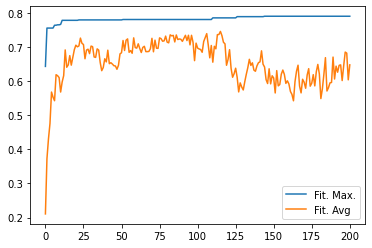

array([0.1722488])

In [31]:
val = ValidacionSimple(0.2)
alg = AlgoritmoGenetico(epochs=200,probMutInd=0.02,maxReglas=5,plot_fitness=True)
alg.validacion(val,dataTitanic)

Como se puede ver, el algoritmo encuentra un individuo con muy buen fitness muy rápidamente (menos de 25 épocas). Sin embargo, sigue siendo capaz de refinalo un poco más hasta la época 130. En cambio, la media fluctúa muchísimo, pero se mantiene en valores que oscilan entre el 0,55 y el 0,75. Está bien que baje mucho respecto al fitness máximo pero sin bajar demasiado, ya que esto nos asegura que sigue habiendo individuos muy diversos.

## 4.2. Tic-Tac-Toe

Ejecutemos con los mejores hiperparámetros el algoritmo genético con una validación simple y veamos cómo evoluciona el fitness:

Época:  0
Fitness medio:  0.003102998696219035
Fitness del mejor individuo:  0.018252933507170794
Época:  1
Fitness medio:  0.010143415906127771
Fitness del mejor individuo:  0.028683181225554105
Época:  2
Fitness medio:  0.012698826597131683
Fitness del mejor individuo:  0.03780964797913951
Época:  3
Fitness medio:  0.020599739243807043
Fitness del mejor individuo:  0.05345501955671447
Época:  4
Fitness medio:  0.028239895697522818
Fitness del mejor individuo:  0.07692307692307693
Época:  5
Fitness medio:  0.03882659713168188
Fitness del mejor individuo:  0.1316818774445893
Época:  6
Fitness medio:  0.06273794002607562
Fitness del mejor individuo:  0.3924380704041721
Época:  7
Fitness medio:  0.1071707953063885
Fitness del mejor individuo:  0.3963494132985658
Época:  8
Fitness medio:  0.1798174706649283
Fitness del mejor individuo:  0.4198174706649283
Época:  9
Fitness medio:  0.2502216427640156
Fitness del mejor individuo:  0.4589308996088657
Época:  10
Fitness medio:  0.283885267275

Época:  41
Fitness medio:  0.5152542372881357
Fitness del mejor individuo:  0.6870925684485006
Época:  42
Fitness medio:  0.5302477183833116
Fitness del mejor individuo:  0.7040417209908736
Época:  43
Fitness medio:  0.5374445893089961
Fitness del mejor individuo:  0.7040417209908736
Época:  44
Fitness medio:  0.5778878748370274
Fitness del mejor individuo:  0.7040417209908736
Época:  45
Fitness medio:  0.5208344198174706
Fitness del mejor individuo:  0.7040417209908736
Época:  46
Fitness medio:  0.5425814863103
Fitness del mejor individuo:  0.7040417209908736
Época:  47
Fitness medio:  0.5601043024771838
Fitness del mejor individuo:  0.7053455019556715
Época:  48
Fitness medio:  0.5248761408083442
Fitness del mejor individuo:  0.7053455019556715
Época:  49
Fitness medio:  0.5354367666232074
Fitness del mejor individuo:  0.7053455019556715
Época:  50
Fitness medio:  0.5522555410691004
Fitness del mejor individuo:  0.7053455019556715
Época:  51
Fitness medio:  0.5487092568448502
Fitness

Época:  82
Fitness medio:  0.5605475880052151
Fitness del mejor individuo:  0.7366362451108214
Época:  83
Fitness medio:  0.5943937418513688
Fitness del mejor individuo:  0.7366362451108214
Época:  84
Fitness medio:  0.5604693611473273
Fitness del mejor individuo:  0.7366362451108214
Época:  85
Fitness medio:  0.5614341590612777
Fitness del mejor individuo:  0.7366362451108214
Época:  86
Fitness medio:  0.5641199478487614
Fitness del mejor individuo:  0.7366362451108214
Época:  87
Fitness medio:  0.5232594524119947
Fitness del mejor individuo:  0.7366362451108214
Época:  88
Fitness medio:  0.5152281616688397
Fitness del mejor individuo:  0.7366362451108214
Época:  89
Fitness medio:  0.5454237288135594
Fitness del mejor individuo:  0.7366362451108214
Época:  90
Fitness medio:  0.586232073011734
Fitness del mejor individuo:  0.7366362451108214
Época:  91
Fitness medio:  0.5023207301173404
Fitness del mejor individuo:  0.7366362451108214
Época:  92
Fitness medio:  0.526857887874837
Fitnes

Época:  123
Fitness medio:  0.5750717079530638
Fitness del mejor individuo:  0.7522816166883963
Época:  124
Fitness medio:  0.5969230769230769
Fitness del mejor individuo:  0.7522816166883963
Época:  125
Fitness medio:  0.5867796610169491
Fitness del mejor individuo:  0.7522816166883963
Época:  126
Fitness medio:  0.5334289439374185
Fitness del mejor individuo:  0.7522816166883963
Época:  127
Fitness medio:  0.5846414602346806
Fitness del mejor individuo:  0.7522816166883963
Época:  128
Fitness medio:  0.6091264667535854
Fitness del mejor individuo:  0.7535853976531942
Época:  129
Fitness medio:  0.6067535853976532
Fitness del mejor individuo:  0.7535853976531942
Época:  130
Fitness medio:  0.5833898305084747
Fitness del mejor individuo:  0.7535853976531942
Época:  131
Fitness medio:  0.5884224250325946
Fitness del mejor individuo:  0.7535853976531942
Época:  132
Fitness medio:  0.601173402868318
Fitness del mejor individuo:  0.7535853976531942
Época:  133
Fitness medio:  0.57580182529

Época:  164
Fitness medio:  0.5901955671447197
Fitness del mejor individuo:  0.7627118644067796
Época:  165
Fitness medio:  0.5692829204693612
Fitness del mejor individuo:  0.7627118644067796
Época:  166
Fitness medio:  0.5589830508474576
Fitness del mejor individuo:  0.7627118644067796
Época:  167
Fitness medio:  0.5589048239895698
Fitness del mejor individuo:  0.7627118644067796
Época:  168
Fitness medio:  0.5639634941329857
Fitness del mejor individuo:  0.7627118644067796
Época:  169
Fitness medio:  0.5735332464146023
Fitness del mejor individuo:  0.7627118644067796
Época:  170
Fitness medio:  0.5972620599739245
Fitness del mejor individuo:  0.7627118644067796
Época:  171
Fitness medio:  0.5716558018252934
Fitness del mejor individuo:  0.7627118644067796
Época:  172
Fitness medio:  0.5545241199478488
Fitness del mejor individuo:  0.7627118644067796
Época:  173
Fitness medio:  0.57251629726206
Fitness del mejor individuo:  0.7627118644067796
Época:  174
Fitness medio:  0.571577574967

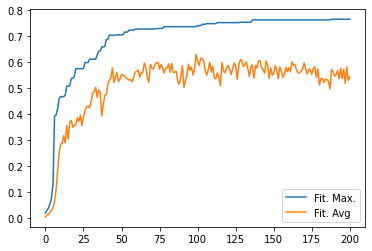

array([0.30890052])

In [23]:
val = ValidacionSimple(0.2)
alg = AlgoritmoGenetico(epochs=200,maxReglas=7,plot_fitness=True)
alg.validacion(val,dataTic)

Como vemos, en este caso el fitness máximo no ha mejorado significativamente desde la época 130. También podemos observar que lo más importante es hacer las 50 primeras épocas, ya que es donde se muestra la mayor mejoría del fitness, con una subida hasta el 0,7. Por otro lado, también vemos que el fitness medio mejora en las primeras épocas, estabilizándose en valores que oscilan el 0,5 y el 0,6 a partir de la época 40.

# 5. Curvas ROC

Para hallar las curvas ROC con Naive-Bayes y nuestro algoritmo genético utilizaremos los hiperparámetros opitimizados de los apartados anteriores. Respecto a Naive-Bayes, el único hiperparámetro digno de mención era si se debía aplicar o no la corrección de laplace. Evidentemente, la utilizaremos, ya que según se demostró en la primera práctica puede o bien no hacer gran cosa o bien mejorar los resultados. A continuación se muestra el código previo de otras prácticas:

In [4]:
import matplotlib.pyplot as plt

# Devuelve los parámetros que interesan de una matriz de confusión a la hora de hacer las curvas ROC
def plot_conf_mat(conf_mat):
    err = (conf_mat[0,1] + conf_mat[1,0])/np.sum(conf_mat)
    tpr = conf_mat[0,0] / np.sum(conf_mat[0])
    fpr = conf_mat[1,0] / np.sum(conf_mat[1])
    x = [0, fpr, 1]
    y = [0, tpr, 1]
    return (x, y, err)

# Muestra las curvas ROC de unos clasificadores escogidos y una cierta base de datos.
def show_roc_curves(clasificadores, datos, proporcionTest=0.3, numeroEjecuciones=1, title='No title'):
    particionado = ValidacionSimple(proporcionTest, numeroEjecuciones)
    errs = np.zeros_like(clasificadores, dtype='float64')
    for i, clsf in enumerate(clasificadores):
        conf_mat= clsf.get_confusion_matrix(particionado,datos)
        x, y, err = plot_conf_mat(conf_mat)
        errs[i] = err
        plt.plot(x, y, label=str(clsf))
    plt.ylabel('sensibilidad')
    plt.xlabel('1 - especificidad')
    plt.title(title)
    plt.legend()
    plt.show()
    return errs

def print_errs(clasificadores,errs):
    for i, clf in enumerate(clasificadores):
        print('Error del clasificador',clf,': ',errs[i]*100,'%')

## 5.1. Titanic

Época:  0
Fitness medio:  0.17579809004092767
Fitness del mejor individuo:  0.6575716234652115
Época:  1
Fitness medio:  0.2621282401091405
Fitness del mejor individuo:  0.703956343792633
Época:  2
Fitness medio:  0.3459208731241473
Fitness del mejor individuo:  0.703956343792633
Época:  3
Fitness medio:  0.3963710777626194
Fitness del mejor individuo:  0.703956343792633
Época:  4
Fitness medio:  0.46130968622100954
Fitness del mejor individuo:  0.7435197817189632
Época:  5
Fitness medio:  0.4494952251023193
Fitness del mejor individuo:  0.7435197817189632
Época:  6
Fitness medio:  0.47667121418826747
Fitness del mejor individuo:  0.7435197817189632
Época:  7
Fitness medio:  0.5385538881309686
Fitness del mejor individuo:  0.7435197817189632
Época:  8
Fitness medio:  0.49809004092769443
Fitness del mejor individuo:  0.7435197817189632
Época:  9
Fitness medio:  0.4626193724420191
Fitness del mejor individuo:  0.7435197817189632
Época:  10
Fitness medio:  0.43860845839017737
Fitness del 

Época:  41
Fitness medio:  0.6330695770804912
Fitness del mejor individuo:  0.7735334242837654
Época:  42
Fitness medio:  0.6454024556616643
Fitness del mejor individuo:  0.7735334242837654
Época:  43
Fitness medio:  0.6198090040927694
Fitness del mejor individuo:  0.7735334242837654
Época:  44
Fitness medio:  0.6150613915416099
Fitness del mejor individuo:  0.7735334242837654
Época:  45
Fitness medio:  0.5986084583901773
Fitness del mejor individuo:  0.7735334242837654
Época:  46
Fitness medio:  0.5423192360163711
Fitness del mejor individuo:  0.7735334242837654
Época:  47
Fitness medio:  0.6001364256480218
Fitness del mejor individuo:  0.7735334242837654
Época:  48
Fitness medio:  0.591487039563438
Fitness del mejor individuo:  0.7735334242837654
Época:  49
Fitness medio:  0.6240109140518418
Fitness del mejor individuo:  0.7735334242837654
Época:  50
Fitness medio:  0.5435743519781718
Fitness del mejor individuo:  0.7735334242837654
Época:  51
Fitness medio:  0.5788267394270123
Fitne

Época:  82
Fitness medio:  0.5518963165075035
Fitness del mejor individuo:  0.7939972714870396
Época:  83
Fitness medio:  0.5513233287858117
Fitness del mejor individuo:  0.7939972714870396
Época:  84
Fitness medio:  0.5068758526603002
Fitness del mejor individuo:  0.7939972714870396
Época:  85
Fitness medio:  0.5422646657571624
Fitness del mejor individuo:  0.7939972714870396
Época:  86
Fitness medio:  0.5499045020463847
Fitness del mejor individuo:  0.7939972714870396
Época:  87
Fitness medio:  0.5865484311050477
Fitness del mejor individuo:  0.7939972714870396
Época:  88
Fitness medio:  0.5474761255115962
Fitness del mejor individuo:  0.7939972714870396
Época:  89
Fitness medio:  0.5494133697135062
Fitness del mejor individuo:  0.7939972714870396
Época:  90
Fitness medio:  0.5147339699863575
Fitness del mejor individuo:  0.7939972714870396
Época:  91
Fitness medio:  0.5380900409276943
Fitness del mejor individuo:  0.7939972714870396
Época:  92
Fitness medio:  0.5607094133697135
Fitn

Época:  123
Fitness medio:  0.6071487039563438
Fitness del mejor individuo:  0.800818553888131
Época:  124
Fitness medio:  0.55118690313779
Fitness del mejor individuo:  0.800818553888131
Época:  125
Fitness medio:  0.5710504774897681
Fitness del mejor individuo:  0.800818553888131
Época:  126
Fitness medio:  0.5893587994542974
Fitness del mejor individuo:  0.800818553888131
Época:  127
Fitness medio:  0.6075852660300137
Fitness del mejor individuo:  0.800818553888131
Época:  128
Fitness medio:  0.5823465211459754
Fitness del mejor individuo:  0.800818553888131
Época:  129
Fitness medio:  0.6124693042291951
Fitness del mejor individuo:  0.800818553888131
Época:  130
Fitness medio:  0.594706684856753
Fitness del mejor individuo:  0.800818553888131
Época:  131
Fitness medio:  0.5925511596180082
Fitness del mejor individuo:  0.800818553888131
Época:  132
Fitness medio:  0.5588813096862211
Fitness del mejor individuo:  0.800818553888131
Época:  133
Fitness medio:  0.4917326057298772
Fitnes

Época:  164
Fitness medio:  0.5748158253751705
Fitness del mejor individuo:  0.800818553888131
Época:  165
Fitness medio:  0.5410368349249659
Fitness del mejor individuo:  0.800818553888131
Época:  166
Fitness medio:  0.5951159618008185
Fitness del mejor individuo:  0.800818553888131
Época:  167
Fitness medio:  0.566057298772169
Fitness del mejor individuo:  0.800818553888131
Época:  168
Fitness medio:  0.5819645293315143
Fitness del mejor individuo:  0.800818553888131
Época:  169
Fitness medio:  0.5702319236016371
Fitness del mejor individuo:  0.800818553888131
Época:  170
Fitness medio:  0.5832196452933152
Fitness del mejor individuo:  0.800818553888131
Época:  171
Fitness medio:  0.5383083219645294
Fitness del mejor individuo:  0.800818553888131
Época:  172
Fitness medio:  0.5464392905866303
Fitness del mejor individuo:  0.800818553888131
Época:  173
Fitness medio:  0.5571896316507504
Fitness del mejor individuo:  0.800818553888131
Época:  174
Fitness medio:  0.6016371077762619
Fitn

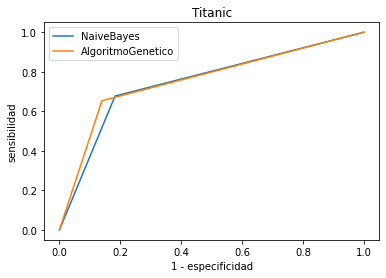

Error del clasificador NaiveBayes :  23.961661341853034 %
Error del clasificador AlgoritmoGenetico :  22.364217252396166 %


In [29]:
clsfNB = ClasificadorNaiveBayes(laplace=True)
clsfAG = AlgoritmoGenetico(epochs=200,probMutInd=0.02,probMutBit=0.005,maxReglas=5)

clfs = [clsfNB, clsfAG]
errs = show_roc_curves(clfs, dataTitanic, title='Titanic')
print_errs(clfs,errs)

Si miramos únicamente el error de clasificación, es mejor el Algoritmo Genético. Además, si miramos el área sobre la curva ROC (criterio más usado para ver qué base de datos es mejor), parece claro que también es mejor el algoritmo genético. 

Esto se debe a que, como se puede ver, tienen una sensibilidad parecida, pero el algoritmo genético tiene bastante más especificidad. 

¿Qué significa esto? Pues que detectan correctamente la misma cantidad de positivos (verdaderos positivos). En cambio, el algoritmo genético es mejor clasificador a la hora de detectar correctamente casos negativos (verdaderos negativos). Es por ello que objetivamente es mejor clasificador en este caso, y cualquier criterio que se use debería verlo así, ya que Naive-Bayes no da ninguna ventaja a la hora de detectar positivos y detecta peor los casos negativos.

## 5.2. Tic-Tac-Toe

Época:  0
Fitness medio:  0.017108792846497765
Fitness del mejor individuo:  0.3561847988077496
Época:  1
Fitness medio:  0.1667064083457526
Fitness del mejor individuo:  0.36661698956780925
Época:  2
Fitness medio:  0.2708196721311475
Fitness del mejor individuo:  0.368107302533532
Época:  3
Fitness medio:  0.2656929955290611
Fitness del mejor individuo:  0.368107302533532
Época:  4
Fitness medio:  0.23782414307004468
Fitness del mejor individuo:  0.37257824143070045
Época:  5
Fitness medio:  0.31588673621460506
Fitness del mejor individuo:  0.38450074515648286
Época:  6
Fitness medio:  0.28289120715350224
Fitness del mejor individuo:  0.39940387481371087
Época:  7
Fitness medio:  0.30429210134128165
Fitness del mejor individuo:  0.39940387481371087
Época:  8
Fitness medio:  0.3086438152011923
Fitness del mejor individuo:  0.39940387481371087
Época:  9
Fitness medio:  0.3152608047690015
Fitness del mejor individuo:  0.4307004470938897
Época:  10
Fitness medio:  0.29645305514157977
Fit

Época:  41
Fitness medio:  0.5595529061102832
Fitness del mejor individuo:  0.6929955290611028
Época:  42
Fitness medio:  0.5431594634873324
Fitness del mejor individuo:  0.6959761549925484
Época:  43
Fitness medio:  0.5698360655737705
Fitness del mejor individuo:  0.7049180327868853
Época:  44
Fitness medio:  0.5680178837555887
Fitness del mejor individuo:  0.7049180327868853
Época:  45
Fitness medio:  0.504381520119225
Fitness del mejor individuo:  0.7049180327868853
Época:  46
Fitness medio:  0.5219374068554395
Fitness del mejor individuo:  0.7049180327868853
Época:  47
Fitness medio:  0.5459016393442623
Fitness del mejor individuo:  0.7049180327868853
Época:  48
Fitness medio:  0.5197615499254843
Fitness del mejor individuo:  0.7049180327868853
Época:  49
Fitness medio:  0.4798211624441133
Fitness del mejor individuo:  0.7049180327868853
Época:  50
Fitness medio:  0.5218777943368107
Fitness del mejor individuo:  0.7049180327868853
Época:  51
Fitness medio:  0.5340983606557377
Fitne

Época:  82
Fitness medio:  0.5776751117734724
Fitness del mejor individuo:  0.7168405365126677
Época:  83
Fitness medio:  0.5692101341281668
Fitness del mejor individuo:  0.7168405365126677
Época:  84
Fitness medio:  0.5628614008941879
Fitness del mejor individuo:  0.7168405365126677
Época:  85
Fitness medio:  0.5502831594634874
Fitness del mejor individuo:  0.7168405365126677
Época:  86
Fitness medio:  0.5412518628912072
Fitness del mejor individuo:  0.7168405365126677
Época:  87
Fitness medio:  0.5315946348733234
Fitness del mejor individuo:  0.7168405365126677
Época:  88
Fitness medio:  0.5194932935916543
Fitness del mejor individuo:  0.7168405365126677
Época:  89
Fitness medio:  0.5264977645305514
Fitness del mejor individuo:  0.7168405365126677
Época:  90
Fitness medio:  0.4991058122205663
Fitness del mejor individuo:  0.7198211624441133
Época:  91
Fitness medio:  0.5372578241430701
Fitness del mejor individuo:  0.7198211624441133
Época:  92
Fitness medio:  0.552220566318927
Fitne

Época:  123
Fitness medio:  0.532160953800298
Fitness del mejor individuo:  0.7198211624441133
Época:  124
Fitness medio:  0.5426527570789866
Fitness del mejor individuo:  0.7198211624441133
Época:  125
Fitness medio:  0.5347242921013413
Fitness del mejor individuo:  0.7198211624441133
Época:  126
Fitness medio:  0.5568107302533533
Fitness del mejor individuo:  0.7198211624441133
Época:  127
Fitness medio:  0.5166318926974665
Fitness del mejor individuo:  0.7198211624441133
Época:  128
Fitness medio:  0.5425931445603577
Fitness del mejor individuo:  0.7198211624441133
Época:  129
Fitness medio:  0.5411624441132639
Fitness del mejor individuo:  0.7198211624441133
Época:  130
Fitness medio:  0.5310879284649777
Fitness del mejor individuo:  0.7198211624441133
Época:  131
Fitness medio:  0.5130849478390462
Fitness del mejor individuo:  0.7198211624441133
Época:  132
Fitness medio:  0.5324888226527571
Fitness del mejor individuo:  0.7242921013412816
Época:  133
Fitness medio:  0.54631892697

Época:  164
Fitness medio:  0.569478390461997
Fitness del mejor individuo:  0.7436661698956781
Época:  165
Fitness medio:  0.5263189269746646
Fitness del mejor individuo:  0.7436661698956781
Época:  166
Fitness medio:  0.5235171385991059
Fitness del mejor individuo:  0.7436661698956781
Época:  167
Fitness medio:  0.5230998509687034
Fitness del mejor individuo:  0.7436661698956781
Época:  168
Fitness medio:  0.5496274217585693
Fitness del mejor individuo:  0.7436661698956781
Época:  169
Fitness medio:  0.5496274217585693
Fitness del mejor individuo:  0.7436661698956781
Época:  170
Fitness medio:  0.5771684053651267
Fitness del mejor individuo:  0.7436661698956781
Época:  171
Fitness medio:  0.5769299552906111
Fitness del mejor individuo:  0.7436661698956781
Época:  172
Fitness medio:  0.5614008941877794
Fitness del mejor individuo:  0.7436661698956781
Época:  173
Fitness medio:  0.5455737704918033
Fitness del mejor individuo:  0.7436661698956781
Época:  174
Fitness medio:  0.52101341281

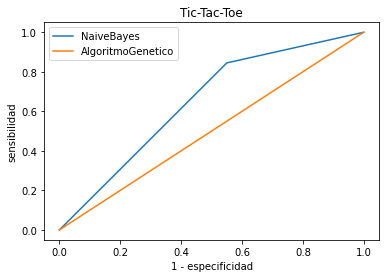

Error del clasificador NaiveBayes :  29.268292682926827 %
Error del clasificador AlgoritmoGenetico :  33.44947735191638 %


In [10]:
clsfNB = ClasificadorNaiveBayes(laplace=True)
clsfAG = AlgoritmoGenetico(epochs=200,maxReglas=7)

clfs = [clsfNB, clsfAG]
errs = show_roc_curves(clfs, dataTic, title='Tic-Tac-Toe')
print_errs(clfs,errs)

No hay lugar a dudas: NaiveBayes es el mejor clasificador en Tic-Tac-Toe según el criterio del área explicado anteriormente. En cuanto al algoritmo genético, se está repitiendo el error observado anteriormente: todo se predice como positivo, por lo que el punto observado es el (1,1). Por lo tanto, el algoritmo genético predice igual que el algoritmo aleatorio en tic-tac-toe.